# Notebook for plotting all the results used in the report

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import json
from scipy.stats import ttest_ind
import pandas as pd
import seaborn as sns

In [3]:
# helper function to output plot and write summary data
def plot_results(results, random_counterpart=None, random_concepts=None, num_random_exp=120,
    min_p_val=0.05, title='TCAV Scores for each concept and bottleneck', show=True):
  """Helper function to organize results.
  When run in a notebook, outputs a matplotlib bar plot of the
  TCAV scores for all bottlenecks for each concept, replacing the
  bars with asterisks when the TCAV score is not statistically significant.
  If you ran TCAV with a random_counterpart, supply it here, otherwise supply random_concepts.
  If you get unexpected output, make sure you are using the correct keywords.
  Args:
    results: dictionary of results from TCAV runs.
    random_counterpart: name of the random_counterpart used, if it was used. 
    random_concepts: list of random experiments that were run. 
    num_random_exp: number of random experiments that were run.
    min_p_val: minimum p value for statistical significance
  """

  # helper function, returns if this is a random concept
  def is_random_concept(concept):
    if random_counterpart:
      return random_counterpart == concept
    
    elif random_concepts:
      return concept in random_concepts

    else:
      return 'random500_' in concept

  # print class, it will be the same for all
#   print("Class =", results[0]['target_class'])

  # prepare data
  # dict with keys of concepts containing dict with bottlenecks
  result_summary = {}
    
  # random
  random_i_ups = {}
    
  for result in results:
    if result['cav_concept'] not in result_summary:
      result_summary[result['cav_concept']] = {}
    
    if result['bottleneck'] not in result_summary[result['cav_concept']]:
      result_summary[result['cav_concept']][result['bottleneck']] = []
    
    result_summary[result['cav_concept']][result['bottleneck']].append(result)

    # store random
    if is_random_concept(result['cav_concept']):
      if result['bottleneck'] not in random_i_ups:
        random_i_ups[result['bottleneck']] = []
        
      random_i_ups[result['bottleneck']].append(result['i_up'])
    
  # to plot, must massage data again 
  plot_data = {}
  plot_concepts = []
    
  # print concepts and classes with indentation
  for concept in result_summary:
        
    # if not random
    if not is_random_concept(concept):
    #   print(" ", "Concept =", concept)
      plot_concepts.append(concept)

      for bottleneck in result_summary[concept]:
        i_ups = [item['i_up'] for item in result_summary[concept][bottleneck]]
        
        # Calculate statistical significance
        _, p_val = ttest_ind(random_i_ups[bottleneck], i_ups)
                  
        if bottleneck not in plot_data:
          plot_data[bottleneck] = {'bn_vals': [], 'bn_stds': [], 'significant': []}

        if p_val > min_p_val:
          # statistically insignificant
          plot_data[bottleneck]['bn_vals'].append(0.01)
          plot_data[bottleneck]['bn_stds'].append(0)
          plot_data[bottleneck]['significant'].append(False)
            
        else:
          plot_data[bottleneck]['bn_vals'].append(np.mean(i_ups))
          plot_data[bottleneck]['bn_stds'].append(np.std(i_ups))
          plot_data[bottleneck]['significant'].append(True)

        # print(3 * " ", "Bottleneck =", ("%s. TCAV Score = %.2f (+- %.2f), "
        #     "random was %.2f (+- %.2f). p-val = %.3f (%s)") % (
        #     bottleneck, np.mean(i_ups), np.std(i_ups),
        #     np.mean(random_i_ups[bottleneck]),
        #     np.std(random_i_ups[bottleneck]), p_val,
        #     "not significant" if p_val > min_p_val else "significant"))
        
  # subtract number of random experiments
  if random_counterpart:
    num_concepts = len(result_summary) - 1
  elif random_concepts:
    num_concepts = len(result_summary) - len(random_concepts)
  else: 
    num_concepts = len(result_summary) - num_random_exp
    
  num_bottlenecks = len(plot_data)
  bar_width = 0.35
    
  # create location for each bar. scale by an appropriate factor to ensure 
  # the final plot doesn't have any parts overlapping
  index = np.arange(num_concepts) * bar_width * (num_bottlenecks + 1)

  # matplotlib
  fig, ax = plt.subplots()
    
  # draw all bottlenecks individually
  for i, [bn, vals] in enumerate(plot_data.items()):
    bar = ax.bar(index + i * bar_width, vals['bn_vals'],
        bar_width, yerr=vals['bn_stds'], label=bn)
    
    # draw stars to mark bars that are stastically insignificant to 
    # show them as different from others
    for j, significant in enumerate(vals['significant']):
      if not significant:
        ax.text(index[j] + i * bar_width - 0.1, 0.01, "*",
            fontdict = {'weight': 'bold', 'size': 16,
            'color': bar.patches[0].get_facecolor()})
#   print (plot_data)
  # set properties
  ax.set_title(title)
  ax.set_ylabel('TCAV Score')
  ax.set_xticks(index + num_bottlenecks * bar_width / 2)
  ax.set_xticklabels(plot_concepts)
  ax.legend()
  fig.tight_layout()
  if show:
    plt.show()
  return plot_data

# Plot just one result

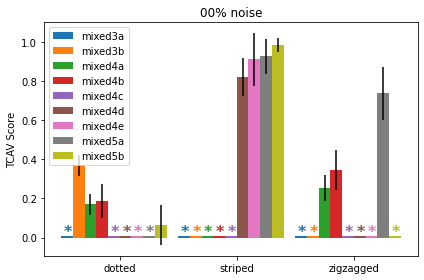

In [4]:
NOISE = 0 # * 10
path = f"results/noisy/results_data_noise{NOISE}0_120_5.json"
res = json.load(open(path))
plot_data = plot_results(res, num_random_exp=5, title=f"{NOISE}0% noise")

#### What the data for each layer looks like

In [5]:
plot_data['mixed3a']

{'bn_vals': [0.01, 0.01, 0.01],
 'bn_stds': [0, 0, 0],
 'significant': [False, False, False]}

# Create dataframe for all noise levels combined

taking the mean here, but the data without taking the mean is already saved in raw in results/

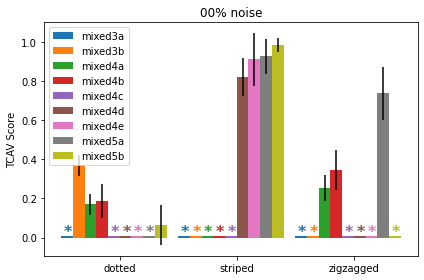

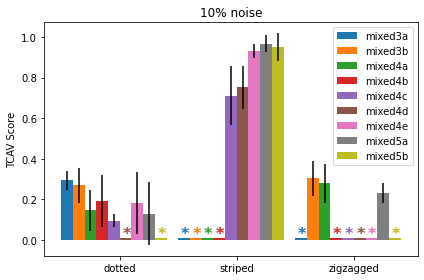

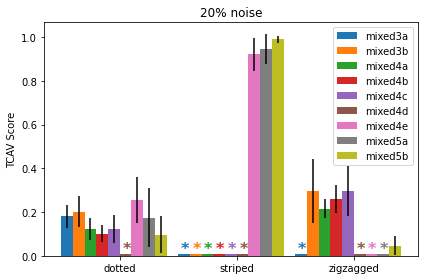

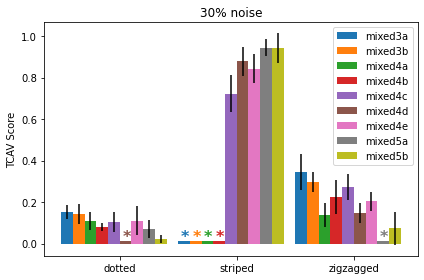

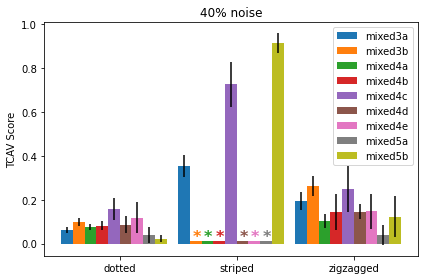

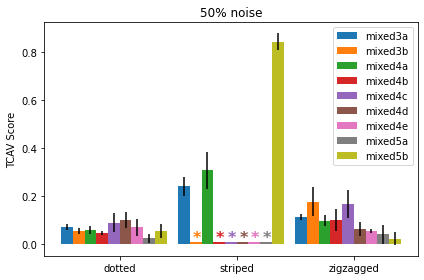

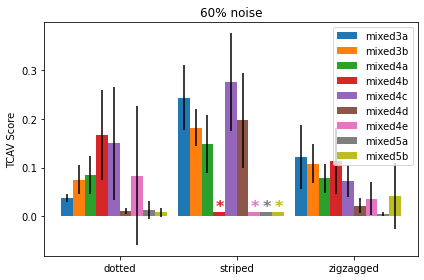

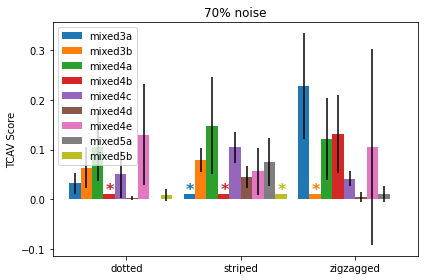

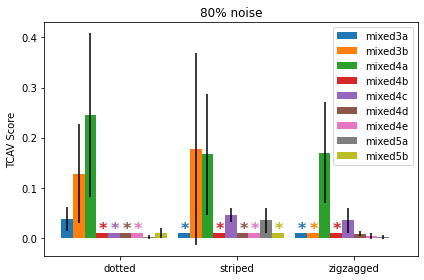

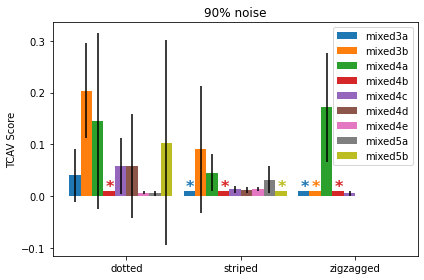

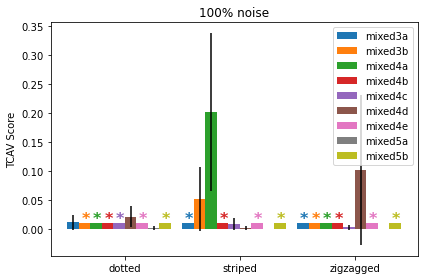

In [6]:
values = []

for i in range(11):

    path = f"results/noisy/results_data_noise{i}0_120_5.json"
    res = json.load(open(path))
    plot_data = plot_results(res, num_random_exp=5, title=f"{i}0% noise", show=False)

    # Take the mean instead of saving for every observation
    vals = []
    stds = []
    for name, val_dict in plot_data.items():
        vals.append(val_dict['bn_vals'])
        stds.append(np.array(val_dict['bn_stds'])**2)
    
    # TODO: Maybe dont take mean of stds to 
    values.append([f"{i}0"] + ["-"] + np.mean(vals,axis=0).tolist() + np.sqrt(np.mean(stds,axis=0)).tolist())

In [7]:
df = pd.DataFrame(values, columns=['noise','name', 'dotted_val', 'striped_val', 'zigzagged_val', 'dotted_std', 'striped_std', 'zigzagged_std'])
df

,noise,name,dotted_val,striped_val,zigzagged_val,dotted_std,striped_std,zigzagged_std
0,00,-,0.093333,0.409815,0.155000,0.051340,0.064089,0.060624
1,10,-,0.147222,0.483889,0.097037,0.097452,0.067197,0.046041
2,20,-,0.140556,0.324259,0.128333,0.076735,0.034543,0.068638
3,30,-,0.088889,0.485926,0.189630,0.040658,0.052370,0.062346
4,40,-,0.082407,0.228519,0.156296,0.035608,0.041403,0.067805
5,50,-,0.063889,0.161667,0.093333,0.025154,0.031505,0.038586
6,60,-,0.070185,0.120556,0.066667,0.070693,0.056759,0.044962
7,70,-,0.044630,0.059815,0.072593,0.046838,0.042332,0.084386
8,80,-,0.051296,0.052593,0.027593,0.064325,0.075898,0.034605
9,90,-,0.070000,0.026111,0.022963,0.101337,0.043646,0.035057


#### Save to csv

In [8]:
# df.to_csv("results/noisy/tcav_results_noisy.csv")
# df.to_csv("results/noisy/tcav_results_mean_noisy.csv")

# Plot using SNS

### Wrangle into something useable by sns for barplot

In [9]:
def create_sns_df(df, concept):
    d = df[[f'{concept}_val', f'{concept}_std']]
    d = d.set_axis(['val', 'std'], axis=1, inplace=False)
    d.insert(0, 'name', df['name'])
    d.insert(0, 'concept', concept)
    return d

In [10]:
df = pd.read_csv("results/noisy/tcav_results_noisy.csv")
df = df[df['noise'] == 0]
df

sns_df = pd.concat([create_sns_df(df, 'zigzagged'),create_sns_df(df, 'striped'), create_sns_df(df, 'dotted')])
sns_df.head()

,concept,name,val,std
0,zigzagged,mixed3a,0.010000,0.000000
1,zigzagged,mixed3b,0.010000,0.000000
2,zigzagged,mixed4a,0.253333,0.068435
3,zigzagged,mixed4b,0.345000,0.100360
4,zigzagged,mixed4c,0.010000,0.000000


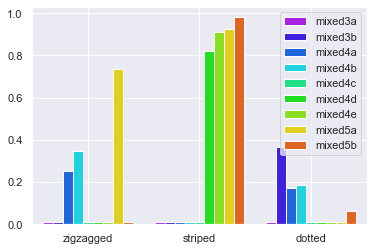

In [11]:

sns.set_theme()
sns.set_palette("gist_rainbow_r", n_colors=9) 
sns.axes_style("darkgrid")

ax = sns.barplot(
    data=sns_df, 
    x='concept', 
    hue='name',
    y="val",
)
ax.set(xlabel=None)
ax.set(ylabel=None)
ax.yaxis.grid(True)
ax.xaxis.grid(True)
# Remove from legend
handles, labels = ax.get_legend_handles_labels()
ax.legend_.set_title(None)

plt.savefig("results/plots/no_noise_results.svg")

# Plot the concepts tcav scores as function of noise level

In [12]:
df = pd.read_csv("results/noisy/tcav_results_mean_noisy.csv")
df.head()

,Unnamed: 0,noise,name,dotted_val,striped_val,zigzagged_val,dotted_std,striped_std,zigzagged_std
0,0,0,-,0.093333,0.409815,0.155000,0.032914,0.039807,0.033795
1,1,10,-,0.147222,0.483889,0.097037,0.078264,0.044534,0.025707
2,2,20,-,0.140556,0.324259,0.128333,0.067254,0.017875,0.045787
3,3,30,-,0.088889,0.485926,0.189630,0.035758,0.038028,0.057295
4,4,40,-,0.082407,0.228519,0.156296,0.030278,0.022296,0.062344


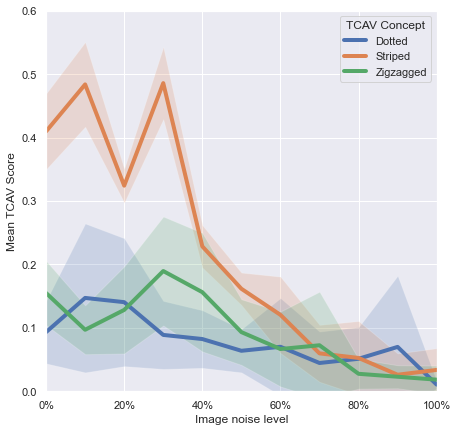

In [13]:
import matplotlib.ticker as mticker    

sns.set_theme()
sns.axes_style("darkgrid")

fig, ax = plt.subplots(figsize=(7,7))

x = df['noise']

ax.fill_between(x, df['dotted_val'] - 1.5*df['dotted_std'], df['dotted_val'] + 1.5*df['dotted_std'], alpha=0.2)
ax.fill_between(x, df['striped_val'] - 1.5*df['striped_std'], df['striped_val'] + 1.5*df['striped_std'], alpha=0.2)
ax.fill_between(x, df['zigzagged_val'] - 1.5*df['zigzagged_std'], df['zigzagged_val'] + 1.5*df['zigzagged_std'], alpha=0.2)

ax.plot(x, df['dotted_val'], '-', label="Dotted", linewidth=4)
ax.plot(x, df['striped_val'], '-', label="Striped", linewidth=4)
ax.plot(x, df['zigzagged_val'], '-', label="Zigzagged", linewidth=4)
ax.set_xlim(0, 100)
ax.set_ylim(0, 0.6)
ax.xaxis.set_major_formatter(mticker.PercentFormatter())

ax.set_ylabel("Mean TCAV Score")
ax.set_xlabel("Image noise level")
ax.legend(title="TCAV Concept")

# plt.savefig("results/plots/tcav_concepts.svg")

# Plot Zebra classification accuracies

In [14]:
def get_class_cols(df):
    return df[['class00%', 'class10%', 'class20%', 'class30%', 'class40%', 'class50%', 'class60%', 'class70%', 'class80%', 'class90%', 'class100%']]

In [15]:
def get_prob_cols(df):
    return df[['prob00%', 'prob10%', 'prob20%', 'prob30%', 'prob40%', 'prob50%', 'prob60%', 'prob70%', 'prob80%', 'prob90%', 'prob100%']]

In [16]:
def stacked_bar_plot(df):
    ax = df.apply(pd.Series.value_counts).transpose().plot.bar(stacked=True, legend=True, figsize=(8,8))
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Raw plot, all classes

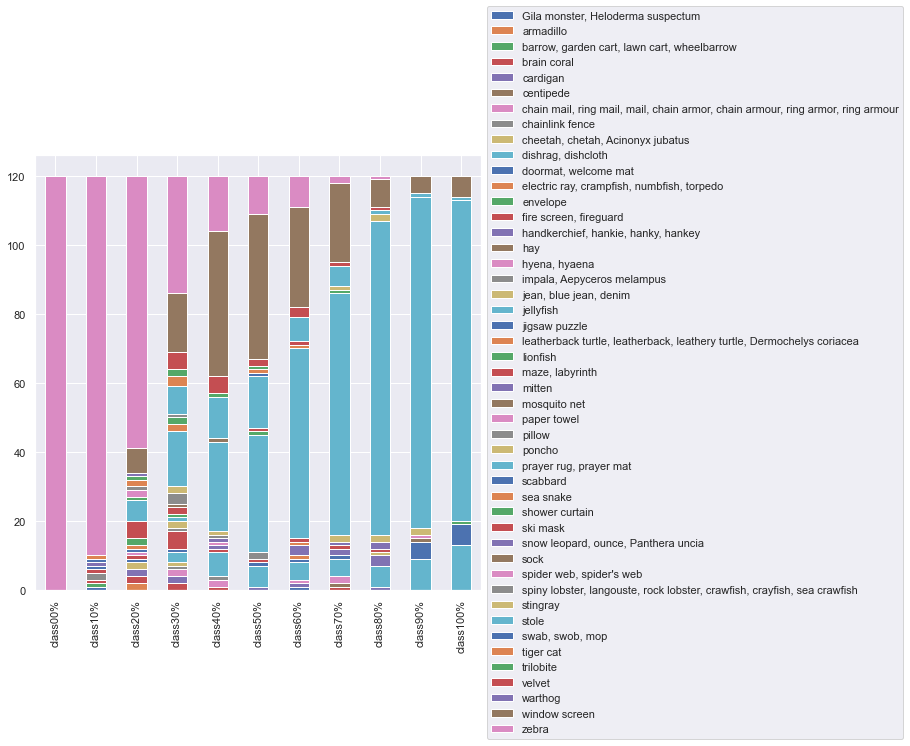

In [17]:
sns.set_theme()
sns.set(rc={'figure.figsize':(7,7)})
sns.axes_style("darkgrid")

df = pd.read_csv("results/noisy/zebra_preds_total.csv")

# Select only class values for now
df = get_class_cols(df)

stacked_bar_plot(df)

### Plots with 4 classes {zebra, rugs, hay, other}

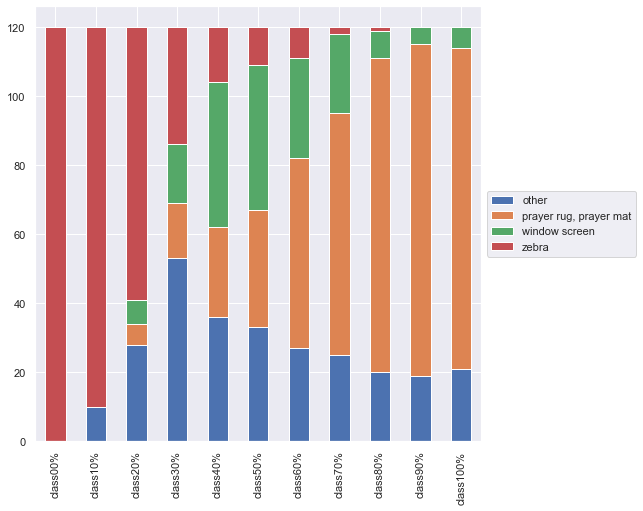

In [18]:
sns.set_theme()
sns.set(rc={'figure.figsize':(7,7)})
sns.axes_style("darkgrid")

df = pd.read_csv("results/noisy/zebra_preds_total.csv")

# Select only class values for now
df = get_class_cols(df)

# Repalce everything but zebra, rugs, hay with other
def replace_other(x):
    if x in ['zebra', "prayer rug, prayer mat", 'window screen']:
        return x
    return 'other'

df = df.applymap(replace_other)

stacked_bar_plot(df)

# Plot with 3 classes

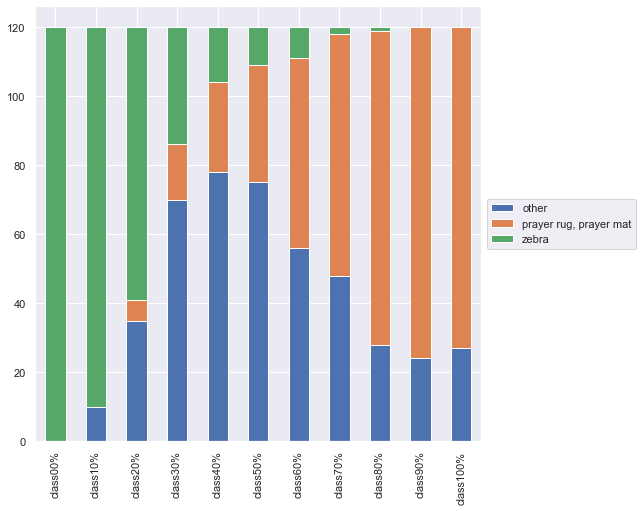

In [19]:
sns.set_theme()
sns.axes_style("darkgrid")

df = pd.read_csv("results/noisy/zebra_preds_total.csv")

# Select only class values for now
df = get_class_cols(df)

# Repalce everything but zebra, rugs, hay with other
def replace_other(x):
    if x in ['zebra', "prayer rug, prayer mat"]:
        return x
    return 'other'

df = df.applymap(replace_other)

stacked_bar_plot(df)

# Plot with only two classes

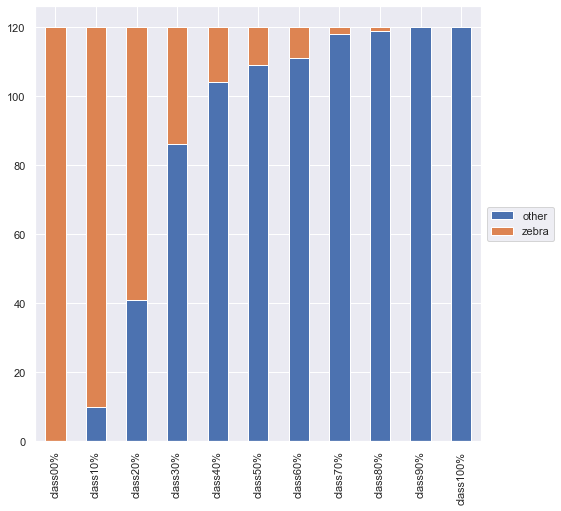

In [20]:
sns.set_theme()
sns.set(rc={'figure.figsize':(7,7)})
sns.axes_style("darkgrid")

df = pd.read_csv("results/noisy/zebra_preds_total.csv")

# Select only class values for now
df = get_class_cols(df)

# Repalce everything but zebra, rugs, hay with other
def replace_other(x):
    return "other" if x != 'zebra' else x

df = df.applymap(replace_other)

stacked_bar_plot(df)

# Make plot of classification accuracy vs. striped score
#### Compute accuracies

In [21]:
noise_df = pd.read_csv("results/noisy/tcav_results_mean_noisy.csv")
preds_df = pd.read_csv("results/noisy/zebra_preds_total.csv")

In [22]:
# Get value counts of zebra to use to compute accuracy across the 120 images
accuracies = []
for i in range(11):

    values_count = preds_df[f'class{i}0%'].value_counts()
    
    try:
        acc = preds_df[f'class{i}0%'].value_counts()['zebra'] / 120.0
        accuracies.append(acc)
    except:
        accuracies.append(0.0)

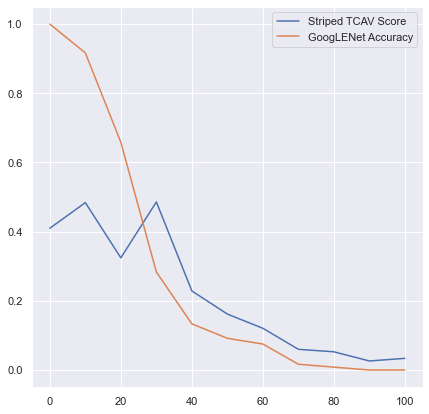

In [23]:
sns.set_theme()
sns.set(rc={'figure.figsize':(7,7)})
sns.axes_style("darkgrid")

fig, ax = plt.subplots(figsize=(7,7))

ax.plot(noise_df['noise'], noise_df['striped_val'], '-', label="Striped TCAV Score")
ax.plot(noise_df['noise'], accuracies, '-', label="GoogLENet Accuracy")

ax.legend()

### Normalizing

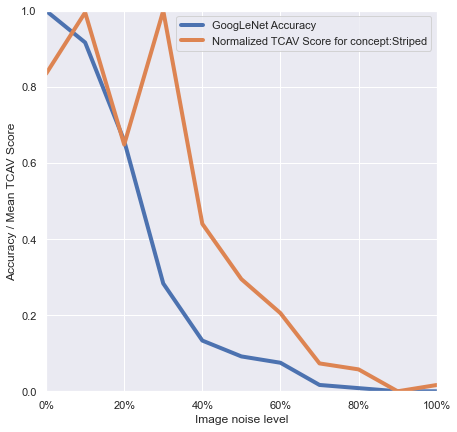

In [24]:
sns.set_theme()
sns.axes_style("darkgrid")

fig, ax = plt.subplots(figsize=(7,7))

xmin = np.min(noise_df['striped_val'])
xmax = np.max(noise_df['striped_val'])

norm = (noise_df['striped_val'] - xmin) / (xmax - xmin)

ax.plot(noise_df['noise'], accuracies, '-', label="GoogLeNet Accuracy", linewidth=4)
ax.plot(noise_df['noise'], norm, '-', label="Normalized TCAV Score for concept:Striped", linewidth=4)

ax.set_xlim(0, 100)
ax.set_ylim(0, 1.0)
ax.xaxis.set_major_formatter(mticker.PercentFormatter())

ax.set_ylabel("Accuracy / Mean TCAV Score")
ax.set_xlabel("Image noise level")
ax.legend()

# plt.savefig("results/plots/accuracy_vs_tcav.svg")

# Plot probability / centainty of predicitions

In [25]:
df = pd.read_csv("results/noisy/zebra_preds_total.csv")

In [26]:
# Convert certainty to 0 in cases where class isnt zebra

def func(number,condition):
    return number if condition == "zebra" else 0.0

for i in range(11):
    df[f'prob{i}0%'] = df.apply(lambda x: func(x[f'prob{i}0%'], x[f'class{i}0%']), axis=1)

In [27]:
df = get_prob_cols(df)
df.head()

,prob00%,prob10%,prob20%,prob30%,prob40%,prob50%,prob60%,prob70%,prob80%,prob90%,prob100%
0,0.983157,0.839316,0.820048,0.255378,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0
1,0.967195,0.963581,0.940977,0.964181,0.747206,0.65230,0.223154,0.0,0.0,0.0,0.0
2,0.926995,0.649212,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0
3,0.659075,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0
4,0.901037,0.911203,0.941489,0.837145,0.637928,0.28291,0.196381,0.0,0.0,0.0,0.0


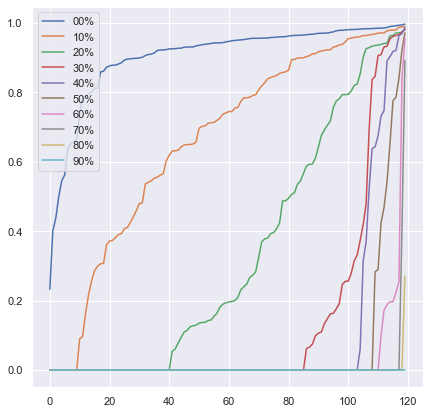

In [28]:
percent = range(0,120)

fig, ax = plt.subplots(figsize=(7,7))

for i in range(10):
    probs = sorted(df[f'prob{i}0%'].tolist(), reverse=False)#df.mean(axis=0).tolist()
    ax.plot(percent, probs, '-', label=f"{i}0%")
    
# ax.plot(percent, accuracies, '-', label="accuracies")
ax.legend()

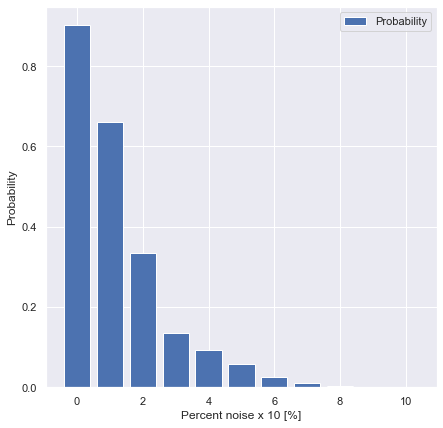

In [29]:
probs = df.mean(axis=0).tolist()
percent = range(0,11)

fig, ax = plt.subplots(figsize=(7,7))

ax.bar(percent, probs, label="Probability")
ax.set_xlabel("Percent noise x 10 [%]")
ax.set_ylabel("Probability")
# ax.plot(percent, accuracies, '-', label="accuracies")
ax.legend()

# Create some plots for the rapport
Get the first 5 images from the three concepts

In [30]:
import os
from mpl_toolkits.axes_grid1 import ImageGrid

base_path = "tcav/data/data_no_noise/"
concepts = ["dotted", "striped", "zigzagged"]
n = 5

all_images = []
for c in concepts:
    for im_name in os.listdir(base_path + "/" + c)[:n]:
        im = plt.imread(f"{base_path}/{c}/{im_name}")
        all_images.append(im)
    

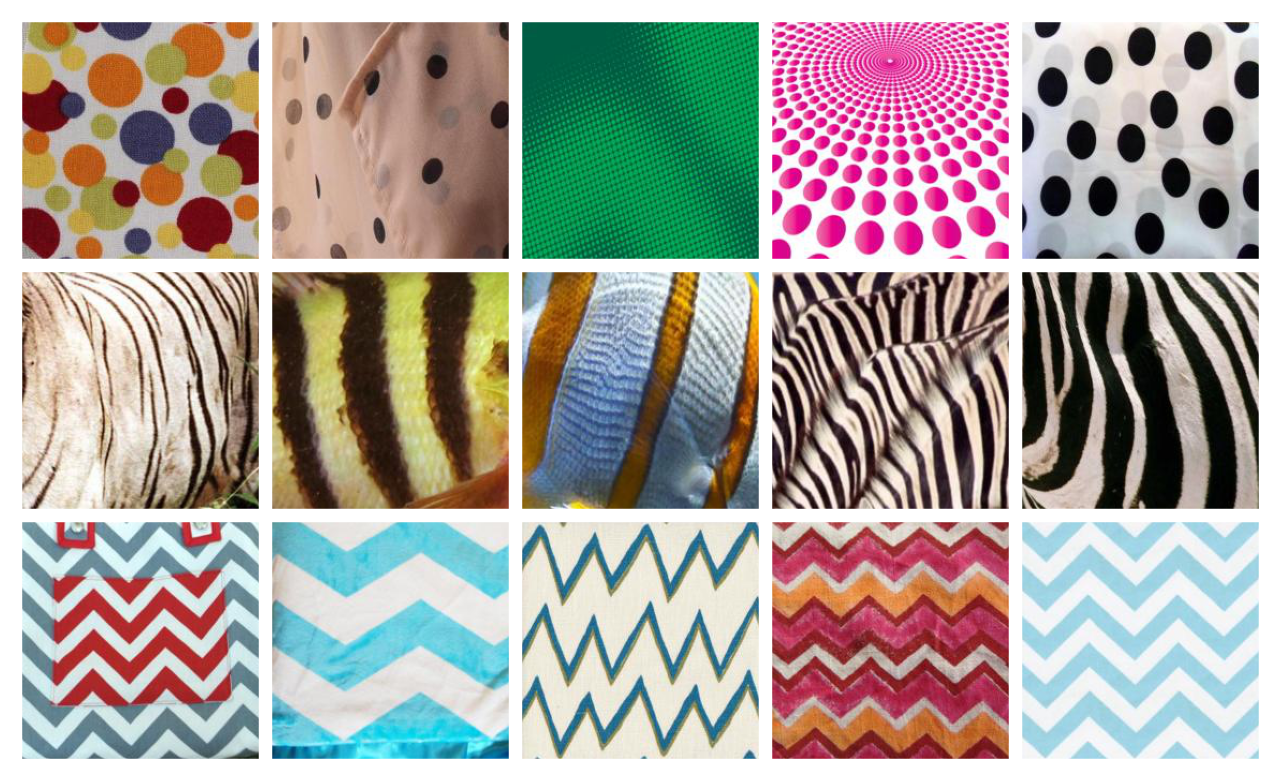

In [66]:
fig = plt.figure(figsize=(8, 8), dpi=200)

grid = ImageGrid(fig, 111, nrows_ncols=(3, 5), axes_pad=0.05, direction="row", share_all=True)
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])

for i, (ax, im) in enumerate(zip(grid, all_images)):
    ax.imshow(im)
    # ax.set_ylabel("test")

# plt.tight_layout()
# plt.savefig("results/plots/examples_images.png")